## **Blackjack**

he Blackjack example is one of the classic illustrations of how Monte Carlo methods can be applied to estimate the optimal policy in a reinforcement learning (RL) task.


### The Blackjack Game Setup:

In the simplified version of Blackjack used in this example:

#### Objective:
The goal of Blackjack is to collect cards whose total value is as close to 21 as possible without exceeding 21.

#### Card Values:
- Cards 2 to 10 are worth their face value.
- Face cards (Jack, Queen, King) are worth 10 points.
- The Ace can be worth 1 or 11 points, whichever is better for the player.

#### Player's Role:
- The player can choose to either hit (take another card) or stick (stop and let the dealer play).

#### Dealer's Role:
- The dealer follows a fixed policy: they must hit until their total is 17 or higher, and then they must stick.

#### Episodes:
An episode is defined as a complete game from the point the player is dealt their cards to the point where the game ends (either a win, loss, or draw).

---

### Key Elements of Blackjack in RL Terms:

- **States**: The state of the game at any point is defined by:
  - The sum of the player’s cards.
  - The value of the dealer’s visible card.
  - Whether the player has a usable ace (i.e., an ace that counts as 11 without the total exceeding 21).

- **Actions**:
  - **Hit**: Take another card.
  - **Stick**: Stop and let the dealer play.

- **Rewards**:
  - $+1$ if the player wins.
  - $0$ if it’s a draw.
  - $-1$ if the player loses.

---

### Monte Carlo Methods in Blackjack:

In the Blackjack example, Monte Carlo prediction is used to estimate the value function for different states under a given policy (often a random policy or a fixed strategy).

#### The steps are:

1. **Generate Episodes**: 
   - The agent (player) plays multiple rounds of Blackjack following a random policy or some exploratory policy (e.g., epsilon-greedy). The agent’s objective is to explore different possible game scenarios.

2. **State-Action Pairs**: 
   - For each round, you track the sequence of state-action-reward tuples.

   States are described by:
   - The player’s current sum.
   - The dealer’s visible card.
   - Whether the player has a usable ace.
   
   Actions are either "hit" or "stick."

3. **Return Calculation**:
   - Once the game ends (episode terminates), calculate the return $G$ for each state-action pair. This return is the final outcome of the game (win, lose, or draw).

4. **Update the Value Function**:
   - You update the value function $V(s)$ or the action-value function $Q(s,a)$ based on the average of the returns observed after visiting the same state or state-action pair across multiple episodes.
   - The goal is to estimate the expected return for each state or state-action pair under the policy being followed.

5. **Improve the Policy**:
   - Once the value function is estimated, you can improve the policy by selecting actions that lead to the highest value. This is essentially the policy improvement step.

---

### Blackjack Example in Monte Carlo Prediction:

The key idea is that by repeatedly simulating games of Blackjack and collecting the rewards associated with different state-action pairs, the agent can learn to approximate the value of each state under a given policy.

#### How it works in Monte Carlo prediction:

- **First-Visit Monte Carlo**:
  After generating an episode (a complete game of Blackjack), we calculate the returns for each state visited. If it’s the first time a state was visited during that game, we use the observed return to update the value function for that state.

- **Exploration**:
  In order to gather enough data for all states, the player typically uses an exploratory policy (like epsilon-greedy). This ensures that the agent tries different actions in different situations, rather than always sticking to a particular strategy.




In [1]:
import random
import numpy as np
from typing import List, Optional, Tuple
from utils import *

class BlackJackEnv:
    def __init__(self) -> None:
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        self.player = []
        self.dealer = []
        self.actions = ["hit", "stick"]
        
    def draw_card(self)->int:
        """Draw a random card from the deck"""
        return random.choice(self.deck)
    
    def hand_value(self, hand:Optional[List[int]])->int:
        """calculate the value of hand"""
        value = sum(hand)
        # special case for Ace, Adjust ace useable, ace is 1 if total (value + 10) is  21 else ace 11 (1 +10)
        if 1 in hand and value + 10 <= 21: 
            return value + 10
        else: 
            return value
        
    def is_bust(self, hand: Optional[List[int]])->bool:
        """Check if hand value is over 21 (bust)."""
        return self.hand_value(hand) > 21
    
    def reset(self):
        """Reset the game and deal initial cards to player and dealer."""
        self.player = [self.draw_card(), self.draw_card()]
        self.dealer =  [self.draw_card(), self.draw_card()]
        return self.__get_observation()
    
    # returns players hand value, dealer's visible card, players usable ace 
    # Basically a state: (18, 12, 1)
    def __get_observation(self)->Tuple[int, int, int]:
        return (self.hand_value(self.player), self.dealer[0], 1 if 1 in self.player else 0)
    
    
    def sample_action(self):
        """Randomly sample an action"""
        return random.choice(self.actions)
    
    
    def step(self, action:str)->Tuple[Tuple[int, int, int], int, bool]:
        """
        Args:
        - action (str): The action to take, either 'hit' or 'stick'.

        Returns: next_state, reward, done => ((18, 10, 1), 0, False)
        - Tuple[Tuple[int, int, int], int, bool]:
        - Observation (Tuple[int, int, int]): A tuple representing the player's hand value, dealer's visible card, and whether the player has a usable ace.
        - Reward (int): The reward for the action (-1 for losing, 1 for winning, 0 for a draw or continuing).
        - Done (bool): Whether the game has ended (True or False).
        """
        
        if action == "hit":
            self.player.append(self.draw_card())
            # player busted
            if self.is_bust(self.player): return self.__get_observation(), -1, True
            # continue game 
            else: return self.__get_observation(), 0, False 
            
        elif action == "stick":
            while self.hand_value(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            if self.is_bust(self.dealer):
                # dealer bust, player wins
                return self.__get_observation(), 1, True
            elif self.hand_value(self.dealer) > self.hand_value(self.player):
                # dealer wins, with higher hand value 
                return self.__get_observation(), -1, True
            elif self.hand_value(self.dealer) < self.hand_value(self.player):
                # player wins, with higher values 
                return self.__get_observation(), 1, True
            else:
                # draw
                return self.__get_observation(), 0, True
        
        else: raise ValueError(f"Unknow action {action}")

**Monte Carlo Prediction Blackjack**

In [2]:
from collections import defaultdict

def mc_blackjack_prediction(env: BlackJackEnv, episodes=10000, gamma=1.0):
    # init state value function
    V = defaultdict(float)
    # store returns for each state 
    returns = defaultdict(list)
    
    for ep in range(episodes):
        episode = []
        state = env.reset()
        done = False
        
        # generate episodes 
        while not done:
            # random policy
            action = env.sample_action()
            next_state, reward, done = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            
        # calculate returns and update V for first visit
        G = 0
        visited_states = set()
        # back-propagate the reward (use gamm discount factor) to starting point
        for state, action, reward in reversed(episode):
            G = reward + gamma * G
            if state not in visited_states:
                returns[state].append(G)
                # first visit -> update state value 
                V[state] = np.mean(returns[state])
                visited_states.add(state)
    return V

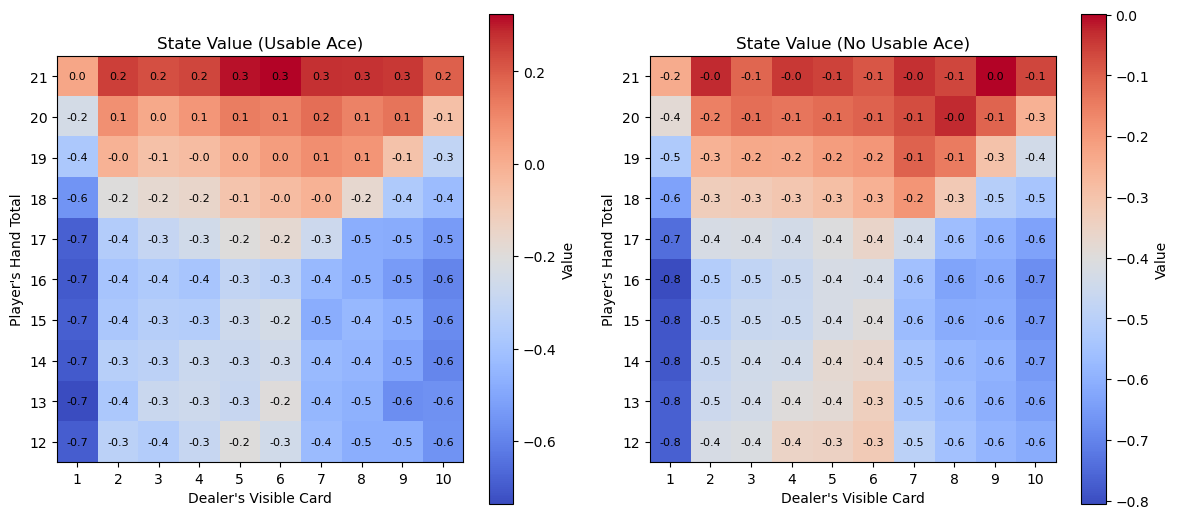

In [3]:
env = BlackJackEnv()
v = mc_blackjack_prediction(env, 500000)
plot_blackjack_values(v)

Imagine you are a Blackjack agent, and you're navigating the casino table, constantly assessing the best possible moves using the knowledge encoded in your state-value heatmaps. Every decision you make is guided by years of Monte Carlo simulations, which have taught you exactly how valuable each hand total is, considering both the dealer’s visible card and whether you have a usable Ace.

Let’s understand how to play the game based on the two heatmaps and maximize your chances of winning.

---

#### **A New Game Begins**

You’re dealt your starting hand: **an Ace and an 8**, giving you a total of **19**, and the dealer’s visible card is a **5**.

**Checking the Heatmap (Usable Ace)**
You check the **usable Ace heatmap**. The state value for **19** against a dealer showing a **5** is **0.0**. This means that, on average, this state gives a neutral expected return — not necessarily a winning or losing position.

- Since the value is neutral, it suggests that your hand is decent but not overwhelmingly strong. However, hitting might push you over 21 and cause a bust.

What do you do? You **stick**. Although the value isn’t strongly positive, sticking with a total of 19 is still the safest choice, as hitting might lead to a bust.

---

#### **The Dealer’s Turn**
The dealer flips over their hidden card, revealing a **7**, bringing their total to **12**. The dealer draws again and gets a **9**, busting with a total of **21**.

You win this round without having to take any further risks. Even though the state value was neutral, sticking was the right decision to avoid busting, and the dealer’s misfortune worked in your favor.

---

#### **A Tougher Situation**

In the next round, you’re dealt a **7 and a 5**, giving you a total of **12**. The dealer shows a **10**. No usable Ace this time.

**Checking the Heatmap (No Usable Ace)**
You consult the **no usable Ace heatmap**. The state value for **12** against a dealer’s **10** is **-0.6** (a dark blue area). This tells you that your chances of winning from this state are quite low, and you need to improve your hand to have any chance of success.

What do you do? You **hit**. You need to try to improve your hand, as sticking would almost certainly lead to a loss.

- You draw a **6**, bringing your total to **18**. You’ve managed to improve your situation.

**Rechecking the Heatmap**
With **18** against the dealer’s **10**, the state value is **-0.5** (light blue area). This is still a negative position, but much better than where you started. Sticking now is your best option, as hitting again could cause you to bust.

You decide to **stick** and hope the dealer busts.

---

#### **The Dealer's Turn**
The dealer flips over their hidden card, revealing a **4**, bringing their total to **14**. They draw another card and receive a **7**, bringing their total to **21**.

The dealer wins. Even though you lost this round, you followed the heatmap’s guidance and improved your chances as much as possible given the circumstances.

---

### **Back in Control: The Power of a Usable Ace**

In the next round, you’re dealt **an Ace and a 6**, giving you a total of **17**, and you have a **usable Ace**. The dealer shows a **4**.

**Checking the Heatmap (Usable Ace)**
You consult the **usable Ace heatmap**. The state value for **17** against a **4** is **-0.4** (blue area). This tells you that your position isn’t great, and you should try to improve your hand.

What do you do? You **hit**.

- You draw a **3**, bringing your total to **20**. Now you’re in a much better position.

**Rechecking the Heatmap**
With **20** against the dealer’s **4**, the heatmap shows a state value of **+0.3** (deep red area). This is a favorable position, and the heatmap suggests that sticking is the best option.

You decide to **stick** and let the dealer take their turn.

---

### **The Dealer’s Turn**
The dealer flips over their hidden card, revealing a **7**, bringing their total to **11**. They draw again, receiving a **10**, and busting with a total of **21**.

You win! In this round, having a usable Ace allowed you to safely hit and improve your hand without worrying about busting, and the heatmap helped guide you to the best possible decision.

---

### **Final Thoughts: A Consistent Strategy Pays Off**

- In situations where you have a **usable Ace**, your strategy becomes more flexible. The heatmap guides you to hit when it’s likely to improve your chances, as it did when you had **17** against a **4**.
- In tougher situations, like having **12** against a **10**, the heatmap accurately warns you that your chances are slim, but it still gives you a path to improve your hand.
- The neutral **state value of 19** against a **5** highlights a scenario where the outcome can swing either way, so taking a safe route by sticking can sometimes be the best choice.

By following the heatmap, you maximize your long-term chances of success in Blackjack, carefully weighing each move and making the most informed decisions possible.

